<a href="https://colab.research.google.com/github/jahnavi-maddhuri/JahnaviMaddhuri-InterpretableML/blob/main/InterpretableML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Interpretable ML** (Assignment 2)

Jahnavi Maddhuri

In [20]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import scipy.stats as stats

### **Load Data**
Load the data and get a an overview of the columns, the size of the a data and a glimpse of the dataset.

In [2]:
path = 'https://raw.githubusercontent.com/jahnavi-maddhuri/JahnaviMaddhuri-InterpretableML/refs/heads/main/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(path)

## **Task 1**
Perform an exploratory analysis of the dataset to understand the relationships between different features and the target variable (churn). Use appropriate visualizations and statistical methods to determine whether assumptions about linear, logistic, and GAM models are met.
<br>

### **EDA**
I first produce some Exploratory visualizations and statistics for my own personal understanding of the dataset.

In [3]:
print('Columns in Dataset:\n', df.columns)
print()
print('Dataset Shape:\n', df.shape)

# See example values of each column
df[['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup']].head()

Columns in Dataset:
 Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Dataset Shape:
 (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No


In [4]:
# Sample values of each column (cont.)
df[['OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']].head()

,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# Convert columns to numeric
df['TotalCharges'] = df['TotalCharges'].astype(str).replace(r'^\s*$', np.nan, regex=True).astype(float)
df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)

# Summary stats on numeric cols
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [7]:
# Churn distribution
df.groupby('Churn').count()[['customerID']].reset_index().rename(columns={'customerID': 'Count'})

,Churn,Count
0,No,5174
1,Yes,1869


There are many more customers who did not churn than that did. This is 2-3x the proportion.

### **Linear Models (OLS) Assumptions**
1. Linearity & additivity of the mean
> Check: residuals vs fitted & partial-residual plots should show no systematic curve; add transforms/splines if you see structure.
PennState: Statistics Online Courses

2. Independence of errors (no autocorrelation).
> Check: residuals vs time/order, ACF/lag plots (or Durbin–Watson) should show no pattern.
NIST ITL

3. Homoscedasticity (constant error variance).
> Check: residuals vs fitted should have constant spread (no funnel); scale–location plot or tests (e.g., BP) if needed.
NIST ITL

4. Approx. normal errors (mainly for small-sample t/F inference).
> Check: Q–Q plot/histogram of residuals roughly bell-shaped. Note: OLS doesn’t require normality for BLUE under Gauss–Markov.

Assumptions and checks generated from ChatGPT 5.0 after I prompted it for assumptions and checks.

In [8]:
# convert churn to numerical
if df['Churn'].dtype != 'float64':
  df['Churn'] = df['Churn'].map({'Yes':1, 'No':0}).astype(float)

# predictors shouldn't include id/churn
X_col_names = [c for c in df.columns if c not in ['customerID', 'Churn']]

# categ/numer variables for formula
categorical = df[X_col_names].select_dtypes(
    include=['object', 'category', 'bool']).columns.tolist()
numerical = [c for c in X_col_names if c not in categorical]

# fit ols
formula = f"Churn ~ " + " + ".join([f"C({c})" for c in categorical] + numerical)
fit_df = df[['Churn'] + X_col_names].dropna()
linear_results = smf.ols(formula, data=fit_df).fit()

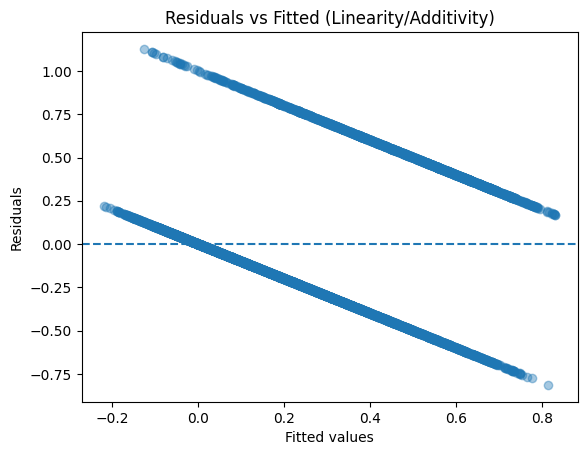

In [9]:
# Assumption 1 and 3: Linearity and Homescedasticity
plt.figure()
plt.scatter(linear_results.fittedvalues, linear_results.resid, alpha=0.4)
plt.axhline(0, ls='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Linearity/Additivity)")
plt.show()

Assumptions 1 and 3 both fail due to the clear pattern in the graph above. There are two distinct lines in the chart (most probably referencing the two distinct target classes, since the target variable is not continuous). The clear line shape fails the linearity assumptions and the clear pattern fails homescedasticity.

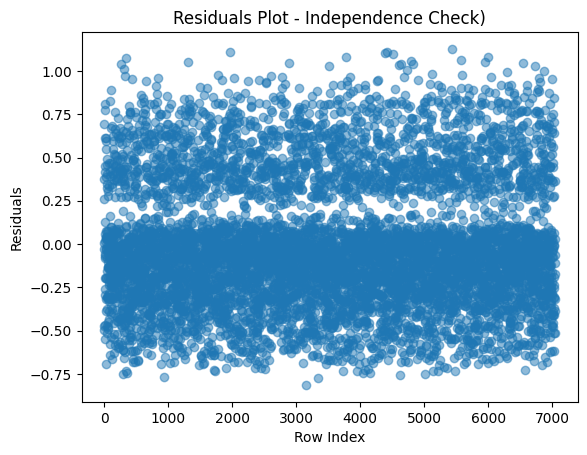

In [10]:
# Assumption 2: Independence of Errors
plt.plot(linear_results.resid, marker='o', linestyle='', alpha=0.5)
plt.xlabel("Row Index")
plt.ylabel("Residuals")
plt.title("Residuals Plot - Independence Check)")
plt.show()

There is a band above 0 where we see a pattern without many points. This fails the independence of errors assumption and is a result of fitting to binary data.

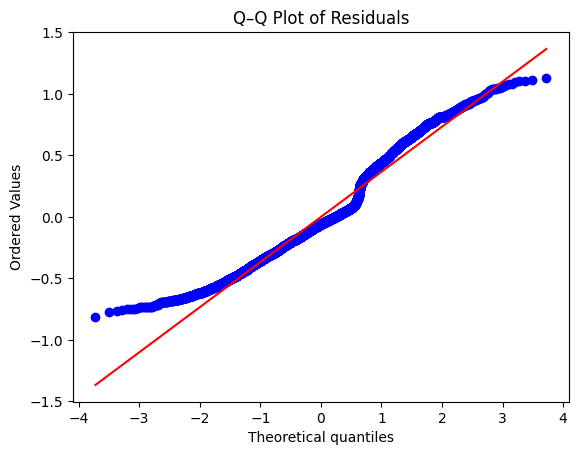

In [11]:
# Assumption 4: Normal Errors
stats.probplot(linear_results.resid, dist="norm", plot=plt)

plt.title("Q–Q Plot of Residuals")
plt.show()

In this curve, we hope to see the blue dots align closely with the red diagonal line. Since there is a strong trend away from the red line, this check also fails.

### **Logistic Regression Model Assumptions**
1. Binary (or binomial) outcome variable
> Check: Verify the target has only two categories. For grouped data (successes/trials), ensure the binomial format is correct.

2. Independence of observations
> Check: Confirm that the dataset has no clustering (e.g., repeated measures for the same subject). If clustering exists, consider mixed-effects logistic regression or GEE.

3. Linearity of continuous predictors with the logit
Logistic regression assumes continuous predictors have a linear relationship with the log-odds of the outcome.
> Check: Use the Box–Tidwell test or partial residual plots. Alternatively, add splines or polynomial terms and see if model fit improves.

4. No (or little) multicollinearity among predictors
> Check: Compute VIF (Variance Inflation Factor). Values > 5 (sometimes > 10) suggest problematic collinearity.

5. Absence of complete or quasi-separation
Logistic regression estimates fail when a predictor perfectly separates the outcome (e.g., whenever X=1, Y=1 always).
> Check: Watch for extremely large coefficients, huge standard errors, or convergence warnings. If present, use penalized logistic regression (e.g., ridge, Firth’s).

6. Large sample size (enough events per predictor variable)
> Check: A common rule-of-thumb is ≥10 events (cases with Y=1) per predictor. For rare outcomes, more is required.

7. Correct variance structure (binomial variance, no overdispersion)
Assumes variance = p(1−p). If variance is larger (overdispersion), SEs and p-values may be off.
> Check: Compare residual deviance to degrees of freedom. If deviance ≫ df, consider quasi-binomial or alternative modeling approaches.

The above assumptions were generated from ChatGPT 5.0 when asked what the model assumptions for logistic regression were.

I first confirm assumptions 1, 2 and 6 hold:
The first assumption, binary outcome variable passes since our outcome variable is Churn which is either 0 or 1. For assumption 2, Observations are independent according to the kaggle website on this data. Assumption 6 also holds since above I found at least 1500 records in each group.

In [19]:
# Assumption 3: Linearity bw cont x and logit y
# capture continuous variables, not just numeric
cont = ['tenure', 'MonthlyCharges', 'TotalCharges']

# add interaction: X * log(X)
for col in cont:
    df[f'{col}_log'] = df[col].apply(lambda x: x if x > 0 else np.nan)
    df[f'{col}_log'] = df[col] * np.log(df[f'{col}_log'])

# formula = X + X*log(X)
formula = 'Churn ~ ' + ' + '.join(cont + [f'C({c})' for c in categorical])
formula += ' + ' + ' + '.join([f'{c}_log' for c in cont])

# log model
logit_model = smf.logit(formula=formula, data=df.dropna()).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.408983
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7006
Method:                           MLE   Df Model:                           25
Date:                Sat, 13 Sep 2025   Pseudo R-squ.:                  0.2937
Time:                        03:50:01   Log-Likelihood:                -2876.0
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                 

To get to the result above, I prompted chatgpt5 to tell me more about the Box Tidwell test and give me an example. Then, I used that sample code, with my data to arrive at the code above. Based on what I learned, if the coefficients in this model are not statistically significant (p>0.05), then there is no evidence of violation of this assumption. In this case, there are many variables with very small p values, the effect of these predictors on the log-odds is not purely linear.

In [24]:
# Assumption 4: Multicollinearity

# take predictors, make dummies for cat, drop na
X = df[X_col_names]
X = pd.get_dummies(X, drop_first=True)
X = add_constant(X)
X = X.astype(float)
X = X.dropna()

# Compute VIF
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                 Variable         VIF
0                                   const    0.000000
1                           SeniorCitizen    1.153220
2                                  tenure    7.584453
3                          MonthlyCharges  866.089640
4                            TotalCharges   10.811490
5                             gender_Male    1.002106
6                             Partner_Yes    1.462988
7                          Dependents_Yes    1.381598
8                        PhoneService_Yes         inf
9          MultipleLines_No phone service         inf
10                      MultipleLines_Yes    7.289761
11            InternetService_Fiber optic  148.500814
12                     InternetService_No         inf
13     OnlineSecurity_No internet service         inf
14                     OnlineSecurity_Yes    6.338349
15       OnlineBackup_No internet service         inf
16                       OnlineBackup_Yes    6.796678
17   DeviceProtection_No int

According to the above VIF scores, there are many that are much larger than 10 and some that even have a score of "infinity." These means that the multicollinearity assumption has been violated and many of these variables are highly correlated.

In [21]:
PhoneService_Yes         inf
9          MultipleLines_No phone service         inf
12                     InternetService_No         inf
13     OnlineSecurity_No internet service         inf
15       OnlineBackup_No internet service         inf
17   DeviceProtection_No internet service         inf
19        TechSupport_No internet service         inf
21        StreamingTV_No internet service         inf
23    StreamingMovies_No internet service         inf

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

In [31]:
# Assumption 5: Quasi-separation
for r in categorical:
  print(r, df[[r, 'Churn']].drop_duplicates().sort_values('Churn'))
  print()

gender    gender  Churn
0  Female    0.0
1    Male    0.0
2    Male    1.0
4  Female    1.0

Partner   Partner  Churn
0     Yes    0.0
1      No    0.0
2      No    1.0
8     Yes    1.0

Dependents    Dependents  Churn
0          No    0.0
6         Yes    0.0
2          No    1.0
18        Yes    1.0

PhoneService    PhoneService  Churn
0            No    0.0
1           Yes    0.0
2           Yes    1.0
20           No    1.0

MultipleLines        MultipleLines  Churn
0   No phone service    0.0
1                 No    0.0
6                Yes    0.0
2                 No    1.0
5                Yes    1.0
20  No phone service    1.0

InternetService    InternetService  Churn
0              DSL    0.0
6      Fiber optic    0.0
11              No    0.0
2              DSL    1.0
4      Fiber optic    1.0
22              No    1.0

OnlineSecurity          OnlineSecurity  Churn
0                    No    0.0
1                   Yes    0.0
11  No internet service    0.0
2                 

This assumption has passed because amongst all the predictors, there isn't one class that completely coincides with the output, Churn. Every predictor category is represented by both Churn responses.